In [1]:
# trick from https://stackoverflow.com/questions/73849624/getting-error-while-submitting-notebook-on-kaggle-even-after-importing-nltk-libr
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import re 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
nltk.download('punkt')
stopwords_en = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 0

Preprocesamiento. Se retiran las columas `Unnamed: 0` y `label`.

In [3]:
df = pd.read_csv('/kaggle/input/data-p4/spam_ham_dataset.csv')
df = df.drop(['Unnamed: 0', 'label'], axis=1)

texto  = df["text"]
labels = df["label_num"]
spam   = df[df["label_num"] == 1]["text"]
ham    = df[df["label_num"] == 0]["text"]

# 1
Crear una función de Python llamada _”preprocess text”_ que reciba una
cadena de texto, a la cual aplique:

1. Tokenización
2. Lower case
3. Eliminar caracteres especiales y numeros
4. Eliminar stop words
5. Quitar cadenas vacias
6. Aplicar lematización

In [5]:
def preprocess_text(text):
    wnl    = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [re.sub("[^A-Za-z]", "", word) for word in tokens]
    tokens = list(filter(None, tokens))
    tokens = [word for word in tokens if word not in stopwords_en]
    tokens = [wnl.lemmatize(word) for word in tokens]
    return tokens

In [6]:
email_text = "Congratulations! You've won a free trip to Hawaii. Click here to claim your prize!"
print(email_text)
# Preprocesamiento del texto del correo electrónico
preprocessed_email = preprocess_text(email_text)
print("Texto preprocesado:", preprocessed_email)

Congratulations! You've won a free trip to Hawaii. Click here to claim your prize!
Texto preprocesado: ['congratulation', 'free', 'trip', 'hawaii', 'click', 'claim', 'prize']


# 2 
Implementación del clasificador spam/ham utilizando bayes ingenuo.

In [20]:
texto_proc = texto.transform(preprocess_text).tolist()
spam_proc  = spam.transform(preprocess_text).tolist()
ham_proc   = ham.transform(preprocess_text).tolist()

In [ ]:
set_spam = set()
for email in spam_proc:
  set_spam.update(set(email))
set_spam

In [ ]:
set_ham = set()
for email in ham_proc:
  set_ham.update(set(email))
set_ham

In [23]:
dict_spamicity = {}
#Obtenemos la proba de que aparezca una palabra dado que es spam
#Iteramos sobre las palabras que aparecen en spam
# Iteramos sobre los correos de spam
total_spam = len(spam)
for palabra in set_spam:
  pInSpam = 0
  for email in spam_proc:
    if palabra in email:
      pInSpam +=1
  if pInSpam ==0:
    proba = 1/total_spam # Parametro
  else:
    proba = pInSpam/total_spam
  dict_spamicity[palabra] = proba
dict_spamicity

{'rumple': 0.0020013342228152103,
 'thu': 0.00600400266844563,
 'gunsh': 0.00066711140760507,
 'bloomington': 0.00266844563042028,
 'upperclassman': 0.00066711140760507,
 'bnc': 0.00066711140760507,
 'snwswutnuc': 0.00066711140760507,
 'witness': 0.00133422281521014,
 'menu': 0.00266844563042028,
 'biel': 0.00066711140760507,
 'diffuser': 0.00066711140760507,
 'giqzfs': 0.00066711140760507,
 'detected': 0.00066711140760507,
 'intersection': 0.00066711140760507,
 'expanding': 0.00867244829886591,
 'fruehauf': 0.00266844563042028,
 'carvencyanamid': 0.00066711140760507,
 'lnoegr': 0.00066711140760507,
 'oncology': 0.00066711140760507,
 'xanagqx': 0.00066711140760507,
 'jyfwf': 0.00066711140760507,
 'missionary': 0.00066711140760507,
 'zibet': 0.00066711140760507,
 'thlt': 0.0020013342228152103,
 'functorial': 0.00066711140760507,
 'fvdc': 0.00066711140760507,
 'caraq': 0.00066711140760507,
 'superior': 0.00533689126084056,
 'accord': 0.0020013342228152103,
 'linen': 0.00066711140760507,


In [25]:
dict_ham = {}
#Obtenemos la proba de que aparezca una palabra dado que es ham
#Iteramos sobre las palabras que aparecen en ham
# Iteramos sobre los correos de ham
total_ham = len(ham)
for palabra in set_ham:
  pInHam = 0
  for email in ham_proc:
    if palabra in email:
      pInHam +=1
  if pInHam ==0:
    proba = 1/total_ham # Parametro
  else:
    proba = pInHam/total_ham
  dict_ham[palabra] = proba
dict_ham

{'relies': 0.0002723311546840959,
 'thu': 0.011982570806100218,
 'timberland': 0.0002723311546840959,
 'erica': 0.0002723311546840959,
 'kristen': 0.010348583877995643,
 'haley': 0.0032679738562091504,
 'inherit': 0.0002723311546840959,
 'invoicing': 0.003812636165577342,
 'witness': 0.0005446623093681918,
 'sexual': 0.0002723311546840959,
 'menu': 0.0029956427015250544,
 'reno': 0.0005446623093681918,
 'pacheco': 0.0002723311546840959,
 'defining': 0.0002723311546840959,
 'currect': 0.0002723311546840959,
 'daate': 0.0002723311546840959,
 'detected': 0.0008169934640522876,
 'similarly': 0.0008169934640522876,
 'expanding': 0.0008169934640522876,
 'dfglynnl': 0.0002723311546840959,
 'risd': 0.0005446623093681918,
 'missionary': 0.0008169934640522876,
 'killam': 0.0002723311546840959,
 'jewelry': 0.0008169934640522876,
 'lindley': 0.006263616557734205,
 'gillespie': 0.0008169934640522876,
 'columbiagas': 0.0005446623093681918,
 'candlelight': 0.0002723311546840959,
 'nomform': 0.0002723

In [26]:
S = total_spam/(total_spam+total_ham)
H = total_ham/(total_spam+total_ham)
print(S, H)

0.2898859021465867 0.7101140978534133


In [27]:
#Preparamos test individuales
tests  = ["""Subject: re : indian springs
this deal is to book the teco pvr revenue . it is my understanding that teco
just sends us a check , i haven ' t received an answer as to whether there is a
predermined price associated with this deal or if teco just lets us know what
we are giving . i can continue to chase this deal down if you need .""", """Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin"""]
tests = [preprocess_text(txt) for txt in tests]

In [28]:
# Quitamos de los emails las palabras que no encontramos
texto_preprocesado = []
for email in tests:
  email_nuevo = []
  for palabra in email:
    if palabra in set_ham:
      email_nuevo.append(palabra)
    else:
      if palabra in set_spam:
        email_nuevo.append(palabra)
  texto_preprocesado.append(email_nuevo)
texto_preprocesado

[['subject',
  'indian',
  'spring',
  'deal',
  'book',
  'teco',
  'pvr',
  'revenue',
  'understanding',
  'teco',
  'sends',
  'u',
  'check',
  'received',
  'answer',
  'whether',
  'predermined',
  'price',
  'associated',
  'deal',
  'teco',
  'let',
  'u',
  'know',
  'giving',
  'continue',
  'chase',
  'deal',
  'need'],
 ['subject',
  'photoshop',
  'window',
  'office',
  'cheap',
  'main',
  'trending',
  'abasement',
  'darer',
  'prudently',
  'fortuitous',
  'undergone',
  'lighthearted',
  'charm',
  'orinoco',
  'taster',
  'railroad',
  'affluent',
  'pornographic',
  'cuvier',
  'irvin',
  'parkhouse',
  'blameworthy',
  'chlorophyll',
  'robed',
  'diagrammatic',
  'fogarty',
  'clear',
  'bayda',
  'inconveniencing',
  'managing',
  'represented',
  'smartness',
  'hashish',
  'academy',
  'shareholder',
  'unload',
  'badness',
  'danielson',
  'pure',
  'caffein',
  'spaniard',
  'chargeable',
  'levin']]

In [29]:
# Preparamos tests para medir metricas
X_, X_test, y_, y_test = train_test_split(texto_2, labels, test_size=0.33, random_state=42)

# Creamos funcion que reciba una lista de probabilidades, multiplique todas y regrese el resultado
def mult(probas) :        # multiplicar todas las probas
    total_prob = 1
    for proba in probas:
      total_prob*=proba
    # Multiplicar todas las probas
    return total_prob
# Creamos funcion que aplique Naive_Bayes a un email, con un threshold como parametro
def Naive_Bayes(email,threshold):
    probs = []
    S # prob_spam
    H # prob_ham
    # Iteramos sobre las palabras del email
    for palabra in email:

    # Calculamos la proba de PdadoS #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
        PdadoS = dict_spamicity[palabra]
      except:
        PdadoS = 1/total_spam
    # Calculamos la proba de PdadoH #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
          PdadoH = dict_ham[palabra]
      except:
          PdadoH = 1/total_ham
    # Aplicamos Bayes para obtener SdadoP
      probaB = PdadoS*S/(PdadoS*S+ PdadoH*H)
      probs.append(probaB)
    # Multiplicamos todas las probas para obtener el total de SdadoEmail
    SdadoEmail = mult(probs)
    # Aplicamos el Threshold para determinar si es o no es spam
    # print(SdadoEmail)
    if SdadoEmail >= threshold:
      SdadoEmail =1
    else:
      SdadoEmail = 0
    return SdadoEmail
for email in texto_preprocesado:
  print(Naive_Bayes(email,.00000000000001))

0
1


In [30]:
y_pred = [Naive_Bayes(email,.00000000000001) for email in X_test]

from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1246
           1       0.69      0.43      0.53       461

    accuracy                           0.80      1707
   macro avg       0.76      0.68      0.70      1707
weighted avg       0.78      0.80      0.78      1707



Text(0.5, 1.0, 'Confusion Matrix')

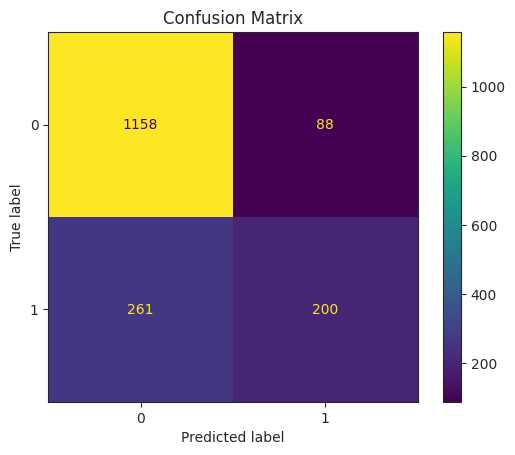

In [31]:
sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
plt.title("Confusion Matrix")